# Updating PH Regions Map
This notebook uses Geopandas and Shapely to generate updated shape files for the Philippine map, reflecting changes in regional boundaries as a result of the [creation of the Negros Island Region (NIR)](http://www.rappler.com/nation/95377-aquino-creates-negros-island-region) in 2015. As I've pointed out in a [previous notebook](https://github.com/ralphqq/inflation_by_region/blob/master/inflation_by_region.ipynb), I've been unable to find open Philippine GIS data sources that already include this adjustment. So, let's do the next best thing and try to create it ourselves.

## Some Preliminaries
The original shape files used here are downloaded from the following:

* [**PhilGIS.org**](http://philgis.org/) - for the regions shape files.
* [**GADM Database**](http://www.gadm.org/download) - for the provincial-level shape files.

**IMPORTANT:** Because of the license terms accompanying the shape files downloaded from the GDAM Database, I did not push those files into this repository. So, in order to run this notebook, please do the following:

1. Go to the [GDAM download page](http://www.gadm.org/download).
2. Choose country data for the Philippines and hit download.
3. Unzip the downloaded zip file.
4. Copy the files with extensions .shp, .dbf, and .shx into the directory named `Original` of this project.

I've also created a csv file containing the 18 regions' respective PSGG codes using data from a [PSA Provinces Summary (2016](http://www.nscb.gov.ph/activestats/psgc/SUMWEBPROV-JUNE2016-CODED-HUC-FINAL.pdf) file. We'll use this later on for easier merging.

To run this notebook, you need to have Geopandas and Shapely **properly installed**. Please see the README file in the root of this repo for the full list of dependencies, and also go through this very helpful [installation tutorial](http://geoffboeing.com/2014/09/using-geopandas-windows/) by Jeff Boeing if you're running this on a Windows machine.

We'll also be using another third-party package `fuzzywuzzy` to help us with matching identical text in our region names. Again, please see the README file for more on installing that package.

Now for the imports:

In [1]:
% matplotlib inline
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from fuzzywuzzy import process

## Reading the Shape Files and PSGG Code File
The shape files are located in the `Original` directory, while the PSGG file is in the root.

In [2]:
regions = gpd.GeoDataFrame.from_file('Original/Regions.shp')
provinces = gpd.GeoDataFrame.from_file('Original/PHL_adm1.shp')
psgg_code = pd.read_csv('psgg_codes.csv', dtype=object)

## Previewing the Data
Let's see if everything checks out.

In [3]:
regions.shape

(17, 2)

In [4]:
regions

,REGION,geometry
0,Autonomous Region of Muslim Mindanao (ARMM),(POLYGON ((119.4669418334962 4.586939811706523...
1,Bicol Region (Region V),(POLYGON ((122.9841690063476 11.71055984497071...
2,CALABARZON (Region IV-A),(POLYGON ((125.2216567993167 10.43443965911868...
3,Cagayan Valley (Region II),(POLYGON ((122.4703979492188 16.91995048522949...
4,Caraga (Region XIII),"(POLYGON ((126.417503356934 7.964169979095546,..."
5,Central Luzon (Region III),(POLYGON ((120.6236267089844 14.36787986755386...
6,Central Visayas (Region VII),(POLYGON ((123.2711105346679 9.084759712219269...
7,Cordillera Administrative Region (CAR),"POLYGON ((121.3767929077149 17.95472908020015,..."
8,Davao Region (Region XI),(POLYGON ((125.3977813720705 5.435830116271932...
9,Eastern Visayas (Region VIII),"(POLYGON ((125.0736083984376 9.89472007751475,..."


As expected, the `regions` GeoDataFrame (which we'll shorten to GDF) contains geometry data for 17 Philippine regions and doesn't yet include data for the NIR.

In [5]:
provinces.shape

(81, 13)

In [6]:
provinces.columns

Index([    u'CCA_1',     u'CCN_1', u'ENGTYPE_1',    u'HASC_1',      u'ID_0',
            u'ID_1',       u'ISO',    u'NAME_0',    u'NAME_1', u'NL_NAME_1',
          u'TYPE_1', u'VARNAME_1',  u'geometry'],
      dtype='object')

In [7]:
cols = ['NAME_1', 'geometry']
provinces.head()[cols]

,NAME_1,geometry
0,Abra,"POLYGON ((120.9679489135743 17.95705986022955,..."
1,Agusan del Norte,"POLYGON ((125.5772399902345 9.456789970397892,..."
2,Agusan del Sur,"POLYGON ((125.9108734130859 8.856249809265194,..."
3,Aklan,(POLYGON ((122.4366683959961 11.59832954406733...
4,Albay,(POLYGON ((123.2876434326172 13.04922962188726...


The `provinces` GDF contains geometry and other data for the 81 Philippine provinces. We previewed this one by specifying only the `NAME_1` and `geometry` columns along with the `.head()` call. Let's see if it has the two provinces we're looking for.

In [8]:
neg_prov = provinces.loc[
    provinces.NAME_1.str.contains(r'Negros'), cols
]
neg_prov

,NAME_1,geometry
50,Negros Occidental,(POLYGON ((122.4352188110356 9.643819808959961...
51,Negros Oriental,"(POLYGON ((123.271110534668 9.084759712219238,..."


And sure enough, it does. Now, onto the updated PSGG codes:

In [9]:
psgg_code.shape

(18, 2)

In [10]:
psgg_code

,psgg_code,region
0,18,NIR (Negros Island Region)
1,13,NCR (National Capital Region)
2,14,CAR (Cordillera Administrative Region)
3,01,Region I (Ilocos Region)
4,02,Region II (Cagayan Valley)
5,03,Region III (Central Luzon)
6,04,Region IV-A (CALABARZON)
7,17,Region IV-B (MIMAROPA)
8,05,Region V (Bicol Region)
9,06,Region VI (Western Visayas)


## Matching and Inserting the PSGG Codes
In order to simplify our dataframe operations later, we match the PSGG codes under the `psgg_code` DF with their corresponding region names in the `regions` GDF and then insert the matched PSGG codes as a new column in the latter. To do this we apply the below function on the `regions` GDF.

The function uses the `process.extractOne()` method of the `fuzzywuzzy` package to match the most identical row from the `psgg_code` DF and use that value to return the corresponding PSGG code.

In [11]:
def get_psgg_code(orig_name):
    if orig_name.startswith('Metropolitan'):
        return '13'
    else:
        choice, _ = process.extractOne(orig_name, psgg_code.region.values)
        p_code = psgg_code.psgg_code[psgg_code.region == choice]
        return p_code.values[0]

In [12]:
regions['psgg_code'] = regions['REGION'].apply(lambda x: get_psgg_code(x))

In [13]:
regions

,REGION,geometry,psgg_code
0,Autonomous Region of Muslim Mindanao (ARMM),(POLYGON ((119.4669418334962 4.586939811706523...,15
1,Bicol Region (Region V),(POLYGON ((122.9841690063476 11.71055984497071...,05
2,CALABARZON (Region IV-A),(POLYGON ((125.2216567993167 10.43443965911868...,04
3,Cagayan Valley (Region II),(POLYGON ((122.4703979492188 16.91995048522949...,02
4,Caraga (Region XIII),"(POLYGON ((126.417503356934 7.964169979095546,...",16
5,Central Luzon (Region III),(POLYGON ((120.6236267089844 14.36787986755386...,03
6,Central Visayas (Region VII),(POLYGON ((123.2711105346679 9.084759712219269...,07
7,Cordillera Administrative Region (CAR),"POLYGON ((121.3767929077149 17.95472908020015,...",14
8,Davao Region (Region XI),(POLYGON ((125.3977813720705 5.435830116271932...,11
9,Eastern Visayas (Region VIII),"(POLYGON ((125.0736083984376 9.89472007751475,...",08


Looks like everything's in order. Let's set the `pscc_code` as the indexx for the `regions` GDF to clear things up a bit and make indexing simpler later.

In [14]:
regions.set_index('psgg_code', inplace=True)
regions

,REGION,geometry
psgg_code,,
15,Autonomous Region of Muslim Mindanao (ARMM),(POLYGON ((119.4669418334962 4.586939811706523...
05,Bicol Region (Region V),(POLYGON ((122.9841690063476 11.71055984497071...
04,CALABARZON (Region IV-A),(POLYGON ((125.2216567993167 10.43443965911868...
02,Cagayan Valley (Region II),(POLYGON ((122.4703979492188 16.91995048522949...
16,Caraga (Region XIII),"(POLYGON ((126.417503356934 7.964169979095546,..."
03,Central Luzon (Region III),(POLYGON ((120.6236267089844 14.36787986755386...
07,Central Visayas (Region VII),(POLYGON ((123.2711105346679 9.084759712219269...
14,Cordillera Administrative Region (CAR),"POLYGON ((121.3767929077149 17.95472908020015,..."
11,Davao Region (Region XI),(POLYGON ((125.3977813720705 5.435830116271932...


## Plotting the Old Regional Shape Files
Let'ss take a "before" snapshot of the previous (pre-2015) regional boundaries, so that we'll have something to remind us of the way things used to be.

In [15]:
# create a series with the region numbers/abbreviations to indicate map locations
def make_map_text(name):
    text = name.split(' ')
    return text[1] if name.startswith('Region') else text[0]

In [16]:
map_names = psgg_code.loc[:, ['psgg_code', 'region']]
map_names['region'] = map_names['region'].apply(lambda x: make_map_text(x))
map_names.set_index('psgg_code', inplace=True, drop=True)

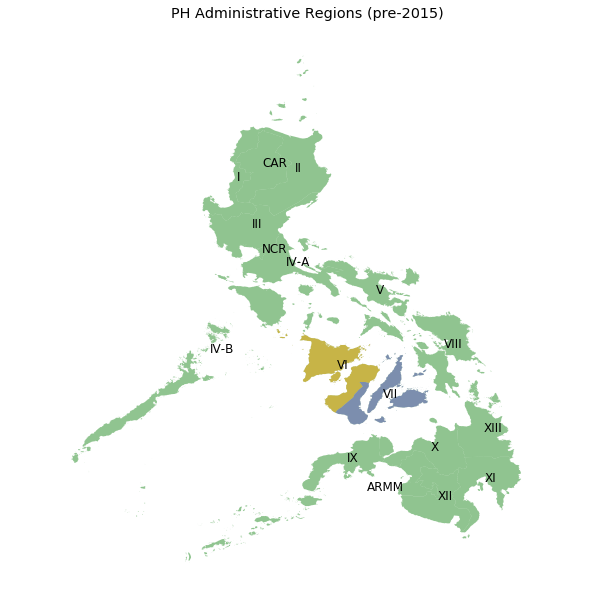

In [17]:
# Plotting it
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 10))

regions.plot(ax=ax, color='forestgreen', linewidth=0)
regions[regions.index == '06'].plot(ax=ax, color='orange', linewidth=0)
regions[regions.index == '07'].plot(ax=ax, color='slateblue', linewidth=0)

for i, point in regions.centroid.iteritems():
    reg_n = map_names.loc[i, 'region']
    ax.text(s=reg_n, x=point.x, y=point.y, fontsize='large')

ax.set_title('PH Administrative Regions (pre-2015)')
ax.set_axis_off()

plt.savefig('map-01-previous.png', bbox_inches='tight')

Here, we plot the old, pre-2015 shape files  and highlight Regions VI and VII (colored orange and slate blue) from the rest of the country (colored forest green). It can be seen that the island of Negros is divided into Regions VI and VII.

## Updating the Regional Boundaries
We're just about ready to modify the previous geometry objects in order to accountfor the creation of the Negros Island Region (NIR) as a separate administrative unit.

The task at hand seems fairly straightforward. We first use the province-level geometry objects for Negros Occidental and Negros Oriental to 'subtract' these shapes from the geometry objects of Regions VI and VII, respectively. Then we take the union of the Negros Occidental and Oriental shapes as the geometry object for NIR.

To do the above steps more quickly and more accurately, we make use of `shapely`'s methods for doing set theoretic operations on geometry objects. We can directly call these methods using any of the entries under the `geometry` fields in our `regions` and `provinces` since each of these entries is either a `shapely` polygon or multipolygon object already.

Enough theory, let's get coding.

In [18]:
# get the shapes of the two provinces (see input cell 8 and its output)
neg_oc = neg_prov.iloc[0, 1]                # Negros Occidental
neg_or = neg_prov.iloc[1, 1]                # Negros Oriental

# get shapes of regions vi and vii
reg_6 = regions.loc['06', 'geometry']
reg_7 = regions.loc['07', 'geometry']

# remove the provinces from their respective pre-2015 regions
regions.loc['06', 'geometry'] = reg_6.difference(neg_oc)
regions.loc['07', 'geometry'] = reg_7.difference(neg_or)

In [19]:
# combining the two provinces' shapes
neg_geom = neg_oc.union(neg_or)

# appending the new region to the regions GDF
neg_reg = gpd.GeoDataFrame([{'REGION': 'Negros Island Region (NIR)',
                             'geometry': neg_geom,
                             'psgg_code': '18'}],
                            columns=['REGION', 'geometry', 'psgg_code'])
neg_reg.set_index('psgg_code', inplace=True, drop=True)
regions = regions.append(neg_reg)
regions

,REGION,geometry
psgg_code,,
15,Autonomous Region of Muslim Mindanao (ARMM),(POLYGON ((119.4669418334962 4.586939811706523...
05,Bicol Region (Region V),(POLYGON ((122.9841690063476 11.71055984497071...
04,CALABARZON (Region IV-A),(POLYGON ((125.2216567993167 10.43443965911868...
02,Cagayan Valley (Region II),(POLYGON ((122.4703979492188 16.91995048522949...
16,Caraga (Region XIII),"(POLYGON ((126.417503356934 7.964169979095546,..."
03,Central Luzon (Region III),(POLYGON ((120.6236267089844 14.36787986755386...
07,Central Visayas (Region VII),(POLYGON ((123.6044769287113 9.300559997558809...
14,Cordillera Administrative Region (CAR),"POLYGON ((121.3767929077149 17.95472908020015,..."
11,Davao Region (Region XI),(POLYGON ((125.3977813720705 5.435830116271932...


In [20]:
regions.shape

(18, 2)

## Plotting the New Shapes
Everything seems to be in order, so far. But the only way to find out for sure is to plot the map. We'll do that here.

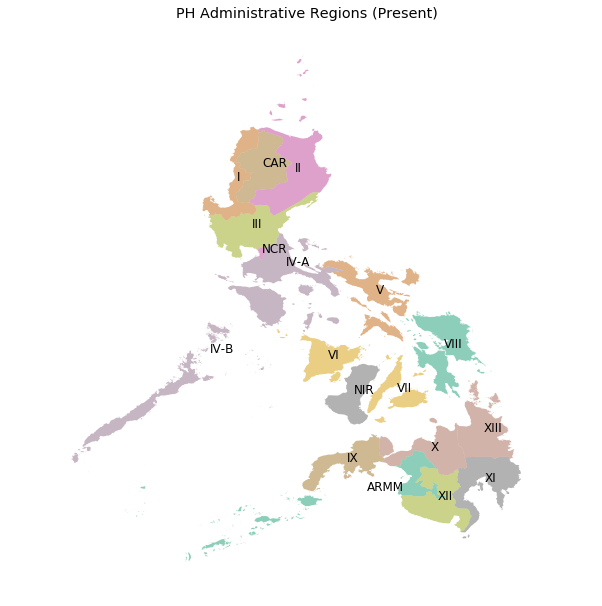

In [21]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 10))

regions.plot(ax=ax, cmap='Dark2', linewidth=0)

for i, point in regions.centroid.iteritems():
    reg_n = map_names.loc[i, 'region']
    ax.text(s=reg_n, x=point.x, y=point.y, fontsize='large')

ax.set_title('PH Administrative Regions (Present)')
ax.set_axis_off()

plt.savefig('map-02-present.png', bbox_inches='tight')

Now, we can see the island of Negros unified under a single administrative unit that's separate from both Regions VI and VII.

## Generating the New Shape Files
Geopandas also makes it easy to generate .shp files and associated file types (.dbf, .shx, etc.). So, we'll do that in this section.

But first, I'm going to make a little modification on the region name for NCR as it currently appears in our `regions` GDF. I'm going to replace it with NCR's official title and include the abbreviation in parentheses for the sake of consistency (plus it's going to make it much easier for anyone to apply regex or string operations on the region names in the future).

In [22]:
regions.loc['13', 'REGION'] = 'National Capital Region (NCR)'
regions

,REGION,geometry
psgg_code,,
15,Autonomous Region of Muslim Mindanao (ARMM),(POLYGON ((119.4669418334962 4.586939811706523...
05,Bicol Region (Region V),(POLYGON ((122.9841690063476 11.71055984497071...
04,CALABARZON (Region IV-A),(POLYGON ((125.2216567993167 10.43443965911868...
02,Cagayan Valley (Region II),(POLYGON ((122.4703979492188 16.91995048522949...
16,Caraga (Region XIII),"(POLYGON ((126.417503356934 7.964169979095546,..."
03,Central Luzon (Region III),(POLYGON ((120.6236267089844 14.36787986755386...
07,Central Visayas (Region VII),(POLYGON ((123.6044769287113 9.300559997558809...
14,Cordillera Administrative Region (CAR),"POLYGON ((121.3767929077149 17.95472908020015,..."
11,Davao Region (Region XI),(POLYGON ((125.3977813720705 5.435830116271932...


Looks good. Now, let's build ourselves some shape files. The following line of code should generate everything we want/need in the `Updated` directory of this project.

In [23]:
regions.to_file('Updated/ph-regions-2015.shp', driver='ESRI Shapefile')

## The Takeaway
Now, we have an up-to-date set of shape files for Philippine regions we can use to visualize region-level data such as the gross regional domestic product (GRDP), regional CPI, regional unemployment rates, or number of stand-up comedians by region.

Just one last thing, I'm making the output data files of this notebook freely available for anyone to download and use under the [Creative Commons Attribution-ShareAlike 4.0 International (CC BY-SA 4.0) license](https://creativecommons.org/licenses/by-sa/4.0/legalcode), but this only applies to the output files and not the original shape files (which may be governed by another license). Please see this project's README file for more on this.